In [3]:
from __future__ import print_function
import random

import torch
import torchvision
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dataset
import torchvision.transforms as transforms
import torchvision.utils as vutils

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import argparse
import os
from tqdm import tqdm
import time
import copy
import math
from zipfile import ZipFile

# To access Google Drive:
from google.colab import drive

from PIL import Image

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# PyTorch's versions:
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
print("NumPy Version: ",np.__version__)
drive.mount("/content/gdrive")

# interactive mode
plt.ion()


manuelSeed = 999

print('Random Seed: '  , manuelSeed )
random.seed(manuelSeed)
torch.manual_seed(manuelSeed)

PyTorch Version:  1.7.0+cu101
Torchvision Version:  0.8.1+cu101
NumPy Version:  1.19.5
Mounted at /content/gdrive
Random Seed:  999


In [4]:
# Root directory for dataset
root_dir = '/content/gdrive/My Drive/Data/Colab'

config = { 'batch_size'        : 128,
           'image_size'        : 64,
           'n_channel'         : 3,
           'latent_space_size' : 100,
           'feature_mapG'      : 64,
           'feature_mapD'      : 64,
           'num_epochs'        : 5,
           'lr'                : 2e-4,
           'beta1'             : 0.5,
           'device'            : 'cuda'
 
}

# We will be working with GPU:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device : ' , device)

# Number of GPUs available. 
num_GPU = torch.cuda.device_count()
print('Number of GPU : ', num_GPU)

Device :  cuda
Number of GPU :  1


In [5]:
def timeit(Func):
    def _timeStamp(*args, **kwargs):
        since = time.time()
        result = Func(*args, **kwargs)
        time_elapsed = time.time() - since

        if time_elapsed > 60:
           print('Time Consumed : {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))  
        else:        
          print('Time Consumed : ' , round((time_elapsed),4) , 's')
        return result
    return _timeStamp

In [6]:
with ZipFile(os.path.join(root_dir,'img_align_celeba.zip'), 'r') as zipObj:
  # Extract all the contents of zip file in current directory
  zipObj.extractall()

In [21]:
class CelebrityData(torch.utils.data.Dataset):

  def __init__(self,root_dir,zip_name,transform = None, zipObj = zipObj, extracted = True) :
    self.root_dir = root_dir
    self.zip_name = zip_name
    self.transform = transform
    

    if not extracted:
      # Create a ZipFile Object and load sample.zip in it
      with ZipFile(os.path.join(self.root_dir,self.zip_name), 'r') as zipObj:
        # Extract all the contents of zip file in current directory
        zipObj.extractall()


    self.ListOfImages = zipObj.namelist()[1:]


  def __getitem__(self,index):

    image = Image.open(self.ListOfImages[index]).convert('RGB')

    if self.transform is not None:
      image = self.transform(image)

    return image


  def __len__(self):
    return  len(self.ListOfImages)

In [22]:
# Note that multiple data augmentation techniques are used to learn generalize better, 

CelebrityData = CelebrityData(root_dir, 
                              zip_name = 'img_align_celeba.zip',
                              transform = transforms.Compose([
                                transforms.ColorJitter([0.9,0.9]),
                                transforms.RandomGrayscale(p = 0.3),
                                transforms.RandomAffine((-30,30)),
                                transforms.RandomPerspective(),
                                transforms.GaussianBlur(3),
                                transforms.RandomHorizontalFlip(p = 0.2),
                                transforms.RandomVerticalFlip(p = 0.2),

                                # Important parts, above can be ignored
                                transforms.Resize(int(config['image_size'] * 1.1)),
                                transforms.CenterCrop(config['image_size']),
                                transforms.ToTensor(),
                                transforms.Normalize(mean = (0.5,0.5,0.5),
                                                     std  = (0.5,0.5,0.5))       
                                
]))

dataloader = torch.utils.data.DataLoader(dataset = CelebrityData,
                                         shuffle = True,
                                         batch_size = config['batch_size'],
                                         num_workers = 2,
                                         drop_last = True,
                                         pin_memory = True) 

In [10]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [11]:
class Generator(nn.Module):
  def __init__(self,latent_space_size = config['latent_space_size'],
               ngf = config['feature_mapG'], n_channel = config['n_channel']):
    
    super(Generator,self).__init__()
     
    self.generator = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( latent_space_size, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, n_channel, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

  def forward(self,inp):
    return self.generator(inp)

In [12]:
netG = Generator().to(device)

if (device.type == 'cuda') and torch.cuda.device_count() > 1:
  netG = nn.DataParallel(netG, list(range(torch.cuda.device_count())))

netG.apply(weights_init)

Generator(
  (generator): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
 

In [13]:
batch = next(iter(dataloader))
print(batch.size())

torch.Size([128, 3, 64, 64])


In [14]:
class Discriminator(nn.Module):
  def __init__(self,n_channel = config['n_channel'], ndf = config['feature_mapD']):
    super(Discriminator,self).__init__()

    self.discriminator = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(n_channel, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    
  @staticmethod
  def linear_block(in_ftrs,out_ftrs,p):
    return nn.Sequential(
        nn.Linear(in_ftrs,out_ftrs),
        nn.BatchNorm1d(out_ftrs),
        nn.ReLU(),
        nn.Dropout(p)
    )

    
  def forward(self,inp):
    return self.discriminator(inp)

In [15]:
netD = Discriminator().to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (torch.cuda.device_count() > 1):
    netD = nn.DataParallel(netD, list(torch.cuda.device_count()))

netD.apply(weights_init)

Discriminator(
  (discriminator): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [16]:
criterion = nn.BCELoss().to(device)

fixed_noise = torch.randn(64, config['latent_space_size'], 1, 1, device=device)

print(fixed_noise.size())


real_label = 1.
fake_label = 0.

optimizerD = optim.Adam(netD.parameters(),
                        lr = config['lr'], 
                        betas = (config['beta1'],0.999))

optimizerG = optim.Adam(netG.parameters(),
                        lr = config['lr'], 
                        betas = (config['beta1'],0.999))

torch.Size([64, 100, 1, 1])


In [14]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")

try :
  if os.path.exists(os.path.join(root_dir,'GAN','GAN_Models','Custom_DCGAN') + '.pth'):
    print('Wearing weights ...')
    checkpoint = torch.load(os.path.join(root_dir,'GAN','GAN_Models','Custom_DCGAN') + '.pth')
    netG.load_state_dict(checkpoint['Generator_state_dict'])
    netD.load_state_dict(checkpoint['Discriminator_state_dict'])  
    netG.to(device)
    netD.to(device)

except RuntimeError as rtr:
  print('Saved Model cannot be loaded...')



# For each epoch
for epoch in range(config['num_epochs']):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data.to(device)
        
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, 100, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)


        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, config['num_epochs'], i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == config['num_epochs']-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                           
              
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
           

        iters += 1



torch.save({'Generator_state_dict' : netG.state_dict(),
            'Discriminator_state_dict' : netD.state_dict(),
            'Generator_optim_state_dict' : optimizerG.state_dict(),
            'Discriminator_optim_state_dict' : optimizerD.state_dict(),
              },           
            os.path.join(root_dir,'GAN','GAN_Models','Custom_DCGAN') + ".pth")

Starting Training Loop...
 Weights worn ...
Saved Model cannot be loaded...
[0/5][0/1582]	Loss_D: 1.7921	Loss_G: 4.7887	D(x): 0.4874	D(G(z)): 0.5501 / 0.0131
[0/5][50/1582]	Loss_D: 2.0231	Loss_G: 27.7343	D(x): 0.4579	D(G(z)): 0.0000 / 0.0000
[0/5][100/1582]	Loss_D: 0.5206	Loss_G: 7.9438	D(x): 0.7956	D(G(z)): 0.0121 / 0.0011
[0/5][150/1582]	Loss_D: 0.5522	Loss_G: 1.9656	D(x): 0.7185	D(G(z)): 0.0986 / 0.1655
[0/5][200/1582]	Loss_D: 1.8251	Loss_G: 1.0403	D(x): 0.3792	D(G(z)): 0.0312 / 0.4549
[0/5][250/1582]	Loss_D: 0.8644	Loss_G: 7.5747	D(x): 0.8734	D(G(z)): 0.4517 / 0.0012
[0/5][300/1582]	Loss_D: 0.6347	Loss_G: 2.8217	D(x): 0.6665	D(G(z)): 0.0657 / 0.0897
[0/5][350/1582]	Loss_D: 0.8982	Loss_G: 5.8123	D(x): 0.9616	D(G(z)): 0.5003 / 0.0074
[0/5][400/1582]	Loss_D: 0.4766	Loss_G: 4.6187	D(x): 0.9252	D(G(z)): 0.2742 / 0.0187
[0/5][450/1582]	Loss_D: 1.0978	Loss_G: 5.7898	D(x): 0.9485	D(G(z)): 0.5797 / 0.0062
[0/5][500/1582]	Loss_D: 0.5003	Loss_G: 5.0686	D(x): 0.9200	D(G(z)): 0.3026 / 0.0124
[0

In [17]:
if not os.path.exists(os.path.join(root_dir,'GAN','GAN_Models')):
  os.mkdir('GAN_Models')


if os.path.exists(os.path.join(root_dir,'GAN','GAN_Models','Custom_DCGAN') + '.pth'):
  print('Wearing weights ...')
  checkpoint = torch.load(os.path.join(root_dir,'GAN','GAN_Models','Custom_DCGAN') + '.pth')
  netG.load_state_dict(checkpoint['Generator_state_dict'])
  netD.load_state_dict(checkpoint['Discriminator_state_dict'])  
  netG.to(device)
  netD.to(device)

Wearing weights ...


In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="Generator")
plt.plot(D_losses,label="Discriminator")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

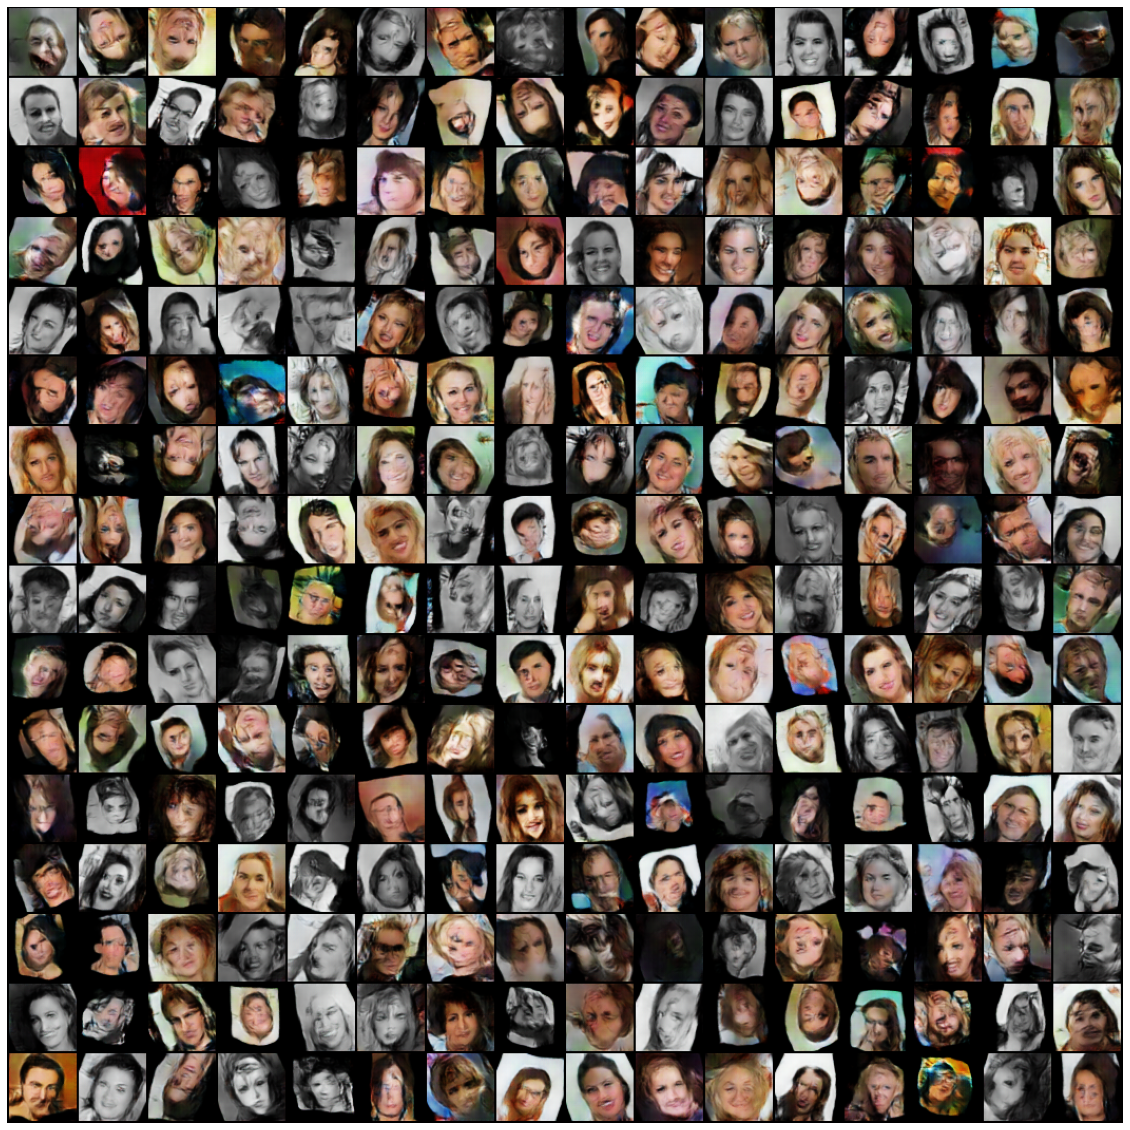

In [18]:
with torch.no_grad():
  netG.eval()
  fakes = netG(torch.randn(256,100,1,1, dtype = torch.float , device = device))

plt.figure(figsize = (20,35))
plt.axis('off')
plt.imshow(vutils.make_grid(fakes, padding=2, normalize=True , nrow= 16).cpu().permute(1,2,0))

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(grid.permute(1,2,0), animated=True)] for grid in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

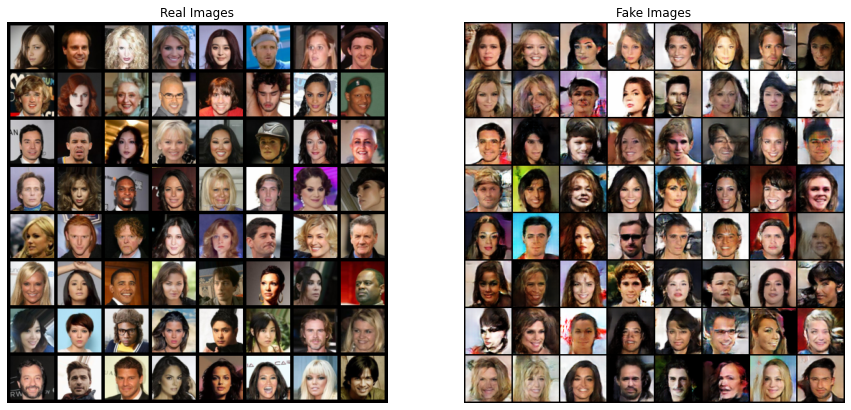

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch.to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()